# Deep Learning & Art: Neural Style Transfer

Welcome to the second assignment of this week. In this assignment, you will learn about Neural Style Transfer. This algorithm was created by Gatys et al. (2015) (https://arxiv.org/abs/1508.06576). 

**In this assignment, you will:**
- Implement the neural style transfer algorithm 
- Generate novel artistic images using your algorithm 

Most of the algorithms you've studied optimize a cost function to get a set of parameter values. In Neural Style Transfer, you'll optimize a cost function to get pixel values!

In [1]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from nst_utils import *
import numpy as np
import tensorflow as tf
import imageio

%matplotlib inline

In [2]:
# GRADED FUNCTION: compute_content_cost

def compute_content_cost(a_C, a_G):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    
    ### START CODE HERE ###
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape a_C and a_G (≈2 lines)
    a_C_unrolled = tf.transpose(tf.reshape(a_C,(n_H*n_W,n_C)))
    a_G_unrolled = tf.transpose(tf.reshape(a_G,(n_H*n_W,n_C)))
    
    # compute the cost with tensorflow (≈1 line)
    J_content = (1/(4*n_H*n_W*n_C))*tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled,a_G_unrolled)),[0,1])
    ### END CODE HERE ###
    
    return J_content

In [3]:
# GRADED FUNCTION: gram_matrix

def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    
    ### START CODE HERE ### (≈1 line)
    GA = tf.matmul(A,A,transpose_b=True)
    ### END CODE HERE ###
    
    return GA

In [4]:
# GRADED FUNCTION: compute_layer_style_cost

def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    ### START CODE HERE ###
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the images to have them of shape (n_C, n_H*n_W) (≈2 lines)
    a_S = tf.transpose(tf.reshape(a_S,(n_H*n_W,n_C)))
    a_G = tf.transpose(tf.reshape(a_G,(n_H*n_W,n_C)))

    # Computing gram_matrices for both images S and G (≈2 lines)
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss (≈1 line)
    J_style_layer = (1/(4*n_C*n_C*n_H*n_H*n_W*n_W))*tf.reduce_sum(tf.square(tf.subtract(GS,GG)),[0,1])

    ### END CODE HERE ###
    
    return J_style_layer

In [5]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [6]:
def compute_style_cost(model, STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    model -- our tensorflow model
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        # Select the output tensor of the currently selected layer
        out = model[layer_name]

        # Set a_S to be the hidden layer activation from the layer we have selected, by running the session on out
        a_S = sess.run(out)

        # Set a_G to be the hidden layer activation from same layer. Here, a_G references model[layer_name] 
        # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
        # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
        a_G = out
        
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer

    return J_style

In [7]:
# GRADED FUNCTION: total_cost

def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    
    ### START CODE HERE ### (≈1 line)
    J = alpha*J_content+beta*J_style
    ### END CODE HERE ###
    
    return J

In [8]:
def imagetransfer(path):
    png = Image.open(path)
    temp=imageio.imread(path)
    if temp.shape[2]==4:
        png.load() # required for png.split()
        transfered = Image.new("RGB", png.size, (255, 255, 255))
        transfered.paste(png, mask=png.split()[3]) # 3 is the alpha channel
        size = 800, 600
        transfered = transfered.resize(size, Image.ANTIALIAS)
        transfered.save(path[:-4]+str("_transfered.png"), 'PNG')
    else:
        size = 800, 600
        transfered = png.resize(size, Image.ANTIALIAS)
        transfered.save(path[:-4]+str("_transfered.png"), 'PNG')
    
    return None


In [9]:
# Reset the graph
tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()

Let's load, reshape, and normalize our "content" image (the Louvre museum picture):

In [10]:
imagetransfer("images/content.jpg")
#im = Image.open("images/Content.png")

content_image = imageio.imread("images/content_transfered.png")
content_image = reshape_and_normalize_image(content_image)

Let's load, reshape and normalize our "style" image (Claude Monet's painting):

In [11]:
imagetransfer("images/style.jpg")
style_image = imageio.imread("images/style_transfered.png")
style_image = reshape_and_normalize_image(style_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


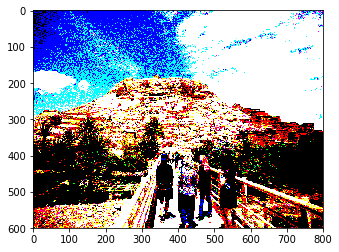

In [12]:
generated_image = generate_noise_image(content_image)
imshow(generated_image[0])

In [13]:
model = load_vgg_model("imagenet-vgg-verydeep-19.mat")

To get the program to compute the content cost, we will now assign `a_C` and `a_G` to be the appropriate hidden layer activations. We will use layer `conv4_2` to compute the content cost. The code below does the following:

1. Assign the content image to be the input to the VGG model.
2. Set a_C to be the tensor giving the hidden layer activation for layer "conv4_2".
3. Set a_G to be the tensor giving the hidden layer activation for the same layer. 
4. Compute the content cost using a_C and a_G.

In [14]:
# Assign the content image to be the input of the VGG model.  
sess.run(model['input'].assign(content_image))

# Select the output tensor of layer conv4_2
out = model['conv4_2']

# Set a_C to be the hidden layer activation from the layer we have selected
a_C = sess.run(out)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
# when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
a_G = out

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

**Note**: At this point, a_G is a tensor and hasn't been evaluated. It will be evaluated and updated at each iteration when we run the Tensorflow graph in model_nn() below.

In [15]:
# Assign the input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))

# Compute the style cost
J_style = compute_style_cost(model, STYLE_LAYERS)

**Exercise**: Now that you have J_content and J_style, compute the total cost J by calling `total_cost()`. Use `alpha = 10` and `beta = 40`.

In [16]:
### START CODE HERE ### (1 line)
J = total_cost(J_content, J_style, alpha = 10, beta = 40)
### END CODE HERE ###

You'd previously learned how to set up the Adam optimizer in TensorFlow. Lets do that here, using a learning rate of 2.0.  [See reference](https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer)

In [17]:
# define optimizer (1 line)
optimizer = tf.train.AdamOptimizer(2.0)

# define train_step (1 line)
train_step = optimizer.minimize(J)

**Exercise**: Implement the model_nn() function which initializes the variables of the tensorflow graph, assigns the input image (initial generated image) as the input of the VGG16 model and runs the train_step for a large number of steps.

In [19]:
def model_nn(sess, input_image, num_iterations = 200):
    
    # Initialize global variables (you need to run the session on the initializer)
    ### START CODE HERE ### (1 line)
    sess.run(tf.global_variables_initializer())
    ### END CODE HERE ###
    
    # Run the noisy input image (initial generated image) through the model. Use assign().
    ### START CODE HERE ### (1 line)
    sess.run(model['input'].assign(input_image))
    ### END CODE HERE ###
    
    for i in range(num_iterations):
    
        # Run the session on the train_step to minimize the total cost
        ### START CODE HERE ### (1 line)
        sess.run(train_step)
        ### END CODE HERE ###
        
        # Compute the generated image by running the session on the current model['input']
        ### START CODE HERE ### (1 line)
        generated_image = sess.run(model['input'])
        ### END CODE HERE ###

        # Print every 20 iteration.
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            # save current generated image in the "/output" directory
            imageio.imwrite("output/" + str(i) + ".png", generated_image[0,:,:,:])
    
    # save last generated image
    imageio.imwrite('output/generated_image.jpg', generated_image[0,:,:,:])
    
    return generated_image

Run the following cell to generate an artistic image. It should take about 3min on CPU for every 20 iterations but you start observing attractive results after ≈140 iterations. Neural Style Transfer is generally trained using GPUs.

In [20]:
model_nn(sess, generated_image)

Iteration 0 :
total cost = 4806184000.0
content cost = 7100.9995
style cost = 120152820.0


Iteration 20 :
total cost = 588750600.0
content cost = 13966.144
style cost = 14715274.0


Iteration 40 :
total cost = 188639570.0
content cost = 14674.828
style cost = 4712320.5


Iteration 60 :
total cost = 101248264.0
content cost = 14993.117
style cost = 2527458.5


Iteration 80 :
total cost = 69632376.0
content cost = 15222.071
style cost = 1737003.9


Iteration 100 :
total cost = 53016096.0
content cost = 15381.91
style cost = 1321556.9


Iteration 120 :
total cost = 42355708.0
content cost = 15524.548
style cost = 1055011.6


Iteration 140 :
total cost = 34833420.0
content cost = 15662.355
style cost = 866919.94


Iteration 160 :
total cost = 29247358.0
content cost = 15790.972
style cost = 727236.2


Iteration 180 :
total cost = 24964008.0
content cost = 15908.042
style cost = 620123.2


array([[[[  36.589428  ,   61.350952  ,   90.24903   ],
         [   0.56424963,  -14.204951  ,   94.48515   ],
         [  13.982318  ,   19.576008  ,   64.91277   ],
         ...,
         [  22.601236  ,    4.65698   ,   35.51818   ],
         [  22.817028  ,   64.512505  ,   65.94818   ],
         [  45.06759   ,   70.47425   ,   64.742195  ]],

        [[ -64.56248   ,  -65.52432   ,  117.66463   ],
         [ -96.6076    ,  -99.09594   ,  -51.00545   ],
         [-115.171616  ,  -96.039024  ,   -6.4300914 ],
         ...,
         [  -2.2073085 ,   -0.9050555 ,   49.918232  ],
         [  14.228032  ,  -15.548121  ,   55.772305  ],
         [  34.160835  ,    7.082944  ,   62.303093  ]],

        [[ -65.42964   ,  -61.41431   ,  101.01641   ],
         [ -81.968544  , -102.898056  ,  -25.475285  ],
         [ -89.35601   ,  -84.83123   ,   25.329248  ],
         ...,
         [ -56.24868   ,   11.063382  ,   46.294605  ],
         [ -39.7039    ,   -5.0279427 ,   47.407696  ],
  

**Expected Output**:

<table>
    <tr>
        <td>
            **Iteration 0 : **
        </td>
        <td>
           total cost = 5.05035e+09 <br>
           content cost = 7877.67 <br>
           style cost = 1.26257e+08
        </td>
    </tr>

</table>

You're done! After running this, in the upper bar of the notebook click on "File" and then "Open". Go to the "/output" directory to see all the saved images. Open "generated_image" to see the generated image! :)

You should see something the image presented below on the right:

<img src="images/louvre_generated.png" style="width:800px;height:300px;">

We didn't want you to wait too long to see an initial result, and so had set the hyperparameters accordingly. To get the best looking results, running the optimization algorithm longer (and perhaps with a smaller learning rate) might work better. After completing and submitting this assignment, we encourage you to come back and play more with this notebook, and see if you can generate even better looking images. 

Here are few other examples:

- The beautiful ruins of the ancient city of Persepolis (Iran) with the style of Van Gogh (The Starry Night)
<img src="images/perspolis_vangogh.png" style="width:750px;height:300px;">

- The tomb of Cyrus the great in Pasargadae with the style of a Ceramic Kashi from Ispahan.
<img src="images/pasargad_kashi.png" style="width:750px;height:300px;">

- A scientific study of a turbulent fluid with the style of a abstract blue fluid painting.
<img src="images/circle_abstract.png" style="width:750px;height:300px;">

## 5 - Test with your own image (Optional/Ungraded)

Finally, you can also rerun the algorithm on your own images! 

To do so, go back to part 4 and change the content image and style image with your own pictures. In detail, here's what you should do:

1. Click on "File -> Open" in the upper tab of the notebook
2. Go to "/images" and upload your images (requirement: (WIDTH = 300, HEIGHT = 225)), rename them "my_content.png" and "my_style.png" for example.
3. Change the code in part (3.4) from :
```python
content_image = scipy.misc.imread("images/louvre.jpg")
style_image = scipy.misc.imread("images/claude-monet.jpg")
```
to:
```python
content_image = scipy.misc.imread("images/my_content.jpg")
style_image = scipy.misc.imread("images/my_style.jpg")
```
4. Rerun the cells (you may need to restart the Kernel in the upper tab of the notebook).

You can also tune your hyperparameters: 
- Which layers are responsible for representing the style? STYLE_LAYERS
- How many iterations do you want to run the algorithm? num_iterations
- What is the relative weighting between content and style? alpha/beta

## 6 - Conclusion

Great job on completing this assignment! You are now able to use Neural Style Transfer to generate artistic images. This is also your first time building a model in which the optimization algorithm updates the pixel values rather than the neural network's parameters. Deep learning has many different types of models and this is only one of them! 

<font color='blue'>
What you should remember:
- Neural Style Transfer is an algorithm that given a content image C and a style image S can generate an artistic image
- It uses representations (hidden layer activations) based on a pretrained ConvNet. 
- The content cost function is computed using one hidden layer's activations.
- The style cost function for one layer is computed using the Gram matrix of that layer's activations. The overall style cost function is obtained using several hidden layers.
- Optimizing the total cost function results in synthesizing new images. 




This was the final programming exercise of this course. Congratulations--you've finished all the programming exercises of this course on Convolutional Networks! We hope to also see you in Course 5, on Sequence models! 


### References:

The Neural Style Transfer algorithm was due to Gatys et al. (2015). Harish Narayanan and Github user "log0" also have highly readable write-ups from which we drew inspiration. The pre-trained network used in this implementation is a VGG network, which is due to Simonyan and Zisserman (2015). Pre-trained weights were from the work of the MathConvNet team. 

- Leon A. Gatys, Alexander S. Ecker, Matthias Bethge, (2015). A Neural Algorithm of Artistic Style (https://arxiv.org/abs/1508.06576) 
- Harish Narayanan, Convolutional neural networks for artistic style transfer. https://harishnarayanan.org/writing/artistic-style-transfer/
- Log0, TensorFlow Implementation of "A Neural Algorithm of Artistic Style". http://www.chioka.in/tensorflow-implementation-neural-algorithm-of-artistic-style
- Karen Simonyan and Andrew Zisserman (2015). Very deep convolutional networks for large-scale image recognition (https://arxiv.org/pdf/1409.1556.pdf)
- MatConvNet. http://www.vlfeat.org/matconvnet/pretrained/


In [ ]:
# Creates a graph.
a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
c = tf.matmul(a, b)
# Creates a session with log_device_placement set to True.
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# Runs the op.
print(sess.run(c))